# Train and Evaluate different models
This will be the main notebook for generating our data for this project. We aim to run experiments on the models and validate our hypothesis

# Install and import dependencies

In [ ]:
! pip install scikit-learn

^C


  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl (8.7 MB)



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd

# Linear Models
from sklearn.linear_model import LogisticRegression

# Support Vector Machines
from sklearn.svm import SVC # "C" stands for Classification

# Decision Trees
from sklearn.tree import DecisionTreeClassifier

# Ensembles (Random Forest)
from sklearn.ensemble import RandomForestClassifier

# Neural Networks
from sklearn.neural_network import MLPClassifier

# Evaluation Metrics
# [cite: 32-33]
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
# Load datasets
def load_into_df(file_path):
    df = pd.read_csv(file_path)
    y = df['Target']
    x = df.drop(columns='Target')
    return x, y

STATIONARY = True

if STATIONARY:
    BASE_PATH = "../data/stationary/"
else:
    BASE_PATH = "../data/"
    

X_train_basic, Y_train_basic = load_into_df(BASE_PATH + "dataset1_train.csv")
print(X_train_basic.head(5), Y_train_basic.head(5))

X_test_basic, Y_test_basic = load_into_df(BASE_PATH+"dataset1_test.csv")

X_train_calculated, Y_train_calculated = load_into_df(BASE_PATH + "dataset2_train.csv")
X_test_calculated, Y_test_calculated = load_into_df(BASE_PATH + "dataset2_test.csv")
datasets = [("basic", X_train_basic, Y_train_basic, X_test_basic, Y_test_basic), ("calculated", X_train_calculated, Y_train_calculated, X_test_calculated, Y_test_calculated)]

   Log_Ret_Close  Log_Ret_Overnight  High_Rel   Low_Rel  Log_Vol_Change
0       0.001727       2.752930e-03  1.004613  0.993709        0.198111
1      -0.016034       1.058689e-07  1.003965  0.983067       -0.086261
2      -0.001850       3.690556e-03  1.001181  0.987249       -0.146046
3       0.006626      -1.330695e-03  1.008084  0.994104       -0.063867
4      -0.008860       3.860972e-03  1.000940  0.979558        0.032138 0    0
1    0
2    1
3    0
4    0
Name: Target, dtype: int64


In [4]:
results = []
models_to_run = {
    "Logistic Regression": LogisticRegression(solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "MLP": MLPClassifier(random_state=42, max_iter=1000),
    # For models that need scaling:
    "P-Logistic Regression": Pipeline([
        ('scaler', StandardScaler()), 
        ('model', LogisticRegression(solver='liblinear'))
    ]),
    "P-SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(random_state=42))
    ]),
    "P-MLP": Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPClassifier(random_state=42, max_iter=1000))
    ]),
    
    # For models that DON'T need scaling:
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

In [5]:
for model_name, model in models_to_run.items():
    for name, X_train, Y_train, X_test, Y_test in datasets:
        print("Training ", model_name, " on ", name)
        model.fit(X_train, Y_train)
        # 2. Get predictions
        y_pred = model.predict(X_test)
        
        # 3. Evaluate (using your proposal's metrics [cite: 29])
        accuracy = accuracy_score(Y_test, y_pred)
        precision = precision_score(Y_test, y_pred)
        recall = recall_score(Y_test,y_pred)
        F1 = f1_score(Y_test, y_pred)
        print(accuracy, precision, recall, F1)

Training  Logistic Regression  on  basic
0.5212765957446809 0.5226969292389854 0.9936548223350253 0.6850393700787402
Training  Logistic Regression  on  calculated
0.523936170212766 0.5245901639344263 0.9746192893401016 0.6820603907637656
Training  Decision Tree  on  basic
0.49867021276595747 0.5211442786069652 0.5317258883248731 0.5263819095477387
Training  Decision Tree  on  calculated
0.4973404255319149 0.52 0.5279187817258884 0.5239294710327456
Training  Random Forest  on  basic
0.4886968085106383 0.5110081112398609 0.5596446700507615 0.5342216838279831
Training  Random Forest  on  calculated
0.504654255319149 0.5246277205040092 0.5812182741116751 0.551475015051174
Training  SVM  on  basic
0.523936170212766 0.5239680426098535 0.998730964467005 0.6873362445414847
Training  SVM  on  calculated
0.523936170212766 0.523936170212766 1.0 0.68760907504363
Training  MLP  on  basic
0.523936170212766 0.5245231607629428 0.9771573604060914 0.6826241134751773
Training  MLP  on  calculated
0.52393

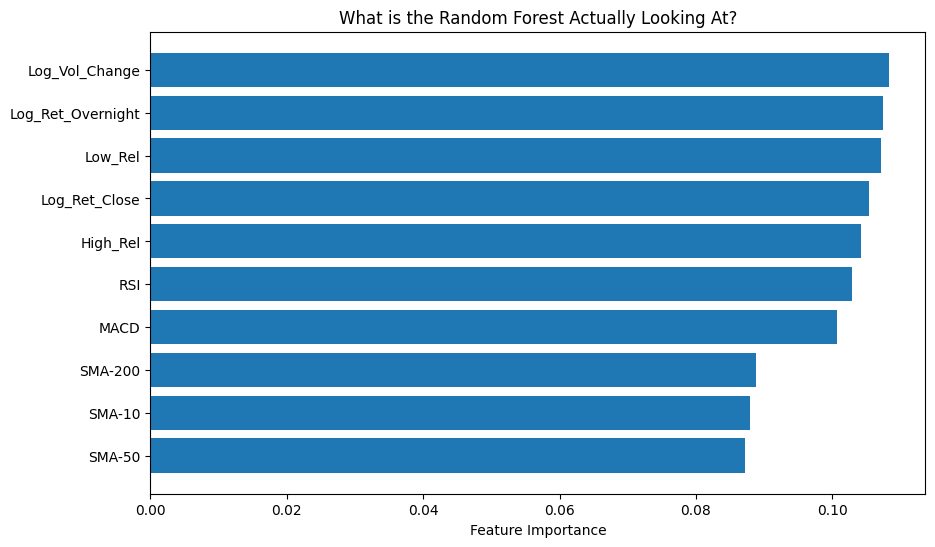

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Fit the Random Forest again on the Calculated dataset
rf_model = models_to_run["Random Forest"]
rf_model.fit(X_train_calculated, Y_train_calculated)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train_calculated.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'])
plt.xlabel('Feature Importance')
plt.title('What is the Random Forest Actually Looking At?')
plt.gca().invert_yaxis()
plt.show()

In [8]:
# Get probabilities instead of just 0/1 predictions
# Use the Scaled MLP or Random Forest
model = models_to_run["P-MLP"] 
model.fit(X_train_calculated, Y_train_calculated)
probs = model.predict_proba(X_test_calculated)[:, 1] # Probability of Class 1 (Up)

# Create a DataFrame of actual vs probability
pred_df = pd.DataFrame({'Actual': Y_test_calculated, 'Prob_Up': probs})

# Filter for "High Confidence" trades (e.g., > 55% probability)
high_confidence_trades = pred_df[pred_df['Prob_Up'] > 0.55]

if len(high_confidence_trades) > 0:
    new_acc = accuracy_score(high_confidence_trades['Actual'], (high_confidence_trades['Prob_Up'] > 0.5).astype(int))
    print(f"Baseline Accuracy: {accuracy_score(Y_test_calculated, model.predict(X_test_calculated)):.4f}")
    print(f"High Confidence Accuracy (>55%): {new_acc:.4f} (on {len(high_confidence_trades)} trades)")
else:
    print("The model is never more than 55% confident.")

Baseline Accuracy: 0.5206
High Confidence Accuracy (>55%): 0.5290 (on 1051 trades)
